In [1]:
from grid_search_tools import GSTools
from distance_method import DistanceStrategy, Metrics
from pair_selector import *

import backtrader as bt
import backtrader.feeds as btfeeds
import pandas as pd
import warnings
import glob
import os
import uuid
import itertools
import json

%load_ext autoreload
%autoreload 2

### Don't touch this

In [2]:
class PandasData(bt.feed.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        ('datetime', 0),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

### Set your params

In [3]:
# INPUT PARAMETERS

DIR = "../ib-data/nyse-daily-tech/"

BT_START_DT = '2017-01-03'

PAIR_FORMATION_LEN = 60

# top PCT percentage of the pairs with lowest distance will be backtested
PCT = 0.01

# STRATEGY PARAMETERS
LOOKBACK_VALUE = [10]
ENTER_THRESHOLD_SIZE = [2]
EXIT_THRESHOLD_SIZE = [0.5]
LOSS_LIMIT = [-0.005]
MAX_LOOKBACK = max(LOOKBACK_VALUE)

# Where to save the ouputs
DST_DIR = "../backtest-results/distance/test1/"

### Save these configurations ...

In [4]:
CONFIG = {
    'DIR': DIR,
    'BT_START_DT': BT_START_DT,
    'PAIR_FORMATION_LEN': PAIR_FORMATION_LEN,
    'PCT': PCT,
    'LOOKBACK_VALUE': LOOKBACK_VALUE,
    'ENTER_THRESHOLD_SIZE': ENTER_THRESHOLD_SIZE,
    'EXIT_THRESHOLD_SIZE': EXIT_THRESHOLD_SIZE,
    'LOSS_LIMIT': LOSS_LIMIT,
    'MAX_LOOKBACK': MAX_LOOKBACK,
    'DST_DIR': DST_DIR,
}

# create json string
CONFIG_JSON_STR = json.dumps(CONFIG)

# create directory if neccessary
if not os.path.exists(DST_DIR):
    os.makedirs(DST_DIR)
    
# save json string to a file
with open(DST_DIR + 'config.json', 'w') as outfile:
    json.dump(CONFIG_JSON_STR, outfile)

### Data wrangling :)

In [5]:
print("---------------------------------------------------------------------")

###################################################################################################################
# Load data
data = GSTools.load_csv_files(DIR)
dt_idx = GSTools.get_trading_dates(data)

print("Initial number of datafeeds: " + str(len(dt_idx)) + ".")

###################################################################################################################
# get position of intended start date of backtest
bt_start_idx = dt_idx.get_loc('2017-01-03')
size = PAIR_FORMATION_LEN + MAX_LOOKBACK + (len(dt_idx) - bt_start_idx)

print("To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = " + str(size) + ".")

# get datafeeds which fulfill size requirement
data = GSTools.cut_datafeeds(data, size=size)

print("After cutting datafeeds, " + str(len(data.keys())) + " datafeeds remaining.")

###################################################################################################################
# just to be safe, sync the start end dates of the dataframes
data, start_dt, end_dt = GSTools.sync_start_end(data)
dt_idx = GSTools.get_trading_dates(data)

###################################################################################################################
# get aggregated close prices
close_df = GSTools.get_aggregated(data, col='close')

if close_df.isnull().values.any():
    warnings.warn("There are null values in the aggregated close price df.")
else:
    print("No null values detected in aggregated close price df.")

###################################################################################################################
# total number of stocks remaining
N = len(data.keys())

# number of pairs of interest
K = int(PCT * N * (N-1) / 2)

print("From " + str(int(N * (N-1) / 2)) + " pairs, pick the top " + str(K) + " pairs in terms of MSE score.")

###################################################################################################################
# pair selection
good_pairs = select_pairs_for_all_combin(train_df=close_df[0:PAIR_FORMATION_LEN], test_df=None,
        config={'n': K, 'score_function': distance_score, 'series_transform': distance_transform}, plot=False)

print("---------------------------------------------------------------------")

---------------------------------------------------------------------
Initial number of datafeeds: 2517.
To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = 575.
After cutting datafeeds, 131 datafeeds remaining.
No null values detected in aggregated close price df.
From 8515 pairs, pick the top 85 pairs in terms of MSE score.
---------------------------------------------------------------------


### OK let's do grid search!

In [6]:
# combinations of parameters
param_combinations = list(itertools.product(LOOKBACK_VALUE, ENTER_THRESHOLD_SIZE, EXIT_THRESHOLD_SIZE, LOSS_LIMIT))

# list to store MACRO results
macro_results = []

for i, params in enumerate(param_combinations, 1):
    # set params
    print("Running " + str(i) + "/" + str(len(param_combinations)))
    print("Backtesting all pairs using parameters " + str(params))
    # list to store MICRO results
    results = []

    for pair in good_pairs:
        # get names of both stock
        stk0, stk1 = pair

        # get data of both stock
        stk0_df, stk1_df = data[stk0], data[stk1]
        stk0_df_test = stk0_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : ]
        stk1_df_test = stk1_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : ]
        
        # Create a cerebro
        cerebro = bt.Cerebro()

        # Create data feeds
        data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
        data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

        # add data feeds to cerebro
        cerebro.adddata(data0)
        cerebro.adddata(data1)

        # Add the strategy
        cerebro.addstrategy(DistanceStrategy, 
                            lookback=params[0],
                            max_lookback=MAX_LOOKBACK,
                            enter_threshold_size=params[1], 
                            exit_threshold_size=params[2], 
                            loss_limit=params[3])

        # Add analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
        cerebro.addanalyzer(Metrics, 
                            lookback=MAX_LOOKBACK, 
                            _name='metrics')

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcash(1000000)

        # And run it
        strat = cerebro.run()

        # get MICRO metrics
        sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
        returnstd = strat[0].analyzers.metrics.returns_std()
        startcash = cerebro.getbroker().startingcash
        endcash = cerebro.getbroker().getvalue()
        profit = (endcash - startcash) / startcash
        
        results.append((stk0 + "-" + stk1, sharperatio, profit, returnstd))
    
    # convert to dataframe
    results_df = pd.DataFrame(results)
    results_df.columns = ['pair', 'sharpe_ratio', 'overall_return', 'returns_std']
    
    # save as csv
    uuid_str = str(uuid.uuid4())
    path = DST_DIR + str(uuid_str) + ".csv" 
    results_df.to_csv(path_or_buf=path, index=False)
    
    # calculate MACRO attributes
    avg_sharpe_ratio = results_df['sharpe_ratio'].mean()
    avg_overall_return = results_df['overall_return'].mean()
    overall_return_std = results_df['overall_return'].std()
    
    macro_results.append((params[0], 
                          params[1], 
                          params[2], 
                          params[3],
                          avg_sharpe_ratio, 
                          avg_overall_return,
                          overall_return_std,
                          uuid_str
                         ))
    
    # nextline
    print("")

macro_results_df = pd.DataFrame(macro_results)
macro_results_df.columns = ['lookback', 
                            'enter_threshold_size', 
                            'exit_threshold_size',
                            'loss_limit', 
                            'avg_sharpe_ratio', 
                            'avg_overall_return', 
                            'overall_return_std',
                            'uuid']
macro_results_df.to_csv(DST_DIR + 'summary.csv', index=False)

Running 1/1
Backtesting all pairs using parameters (10, 2, 0.5, -0.005)
-------------------------------------------------------------------------------------


### Now, if you're interested to look into one specific pair .. 

In [7]:
# set your params
_STK0 = 'CACI'
_STK1 = 'LDOS'
_LOOKBACK = 10
_ENTER_THRESHOLD_SIZE = 2
_EXIT_THRESHOLD_SIZE = 0.5
_LOSS_LIMIT = -0.005

In [8]:
def backtest_single_pair(_stk0, _stk1, _lookback, _enter_threshold_size, _exit_threshold_size, _loss_limit):
    # get data of both stock
    stk0_df, stk1_df = data[_stk0], data[_stk1]
    stk0_df_test = stk0_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : ]
    stk1_df_test = stk1_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : ]

    # Create a cerebro
    cerebro = bt.Cerebro()

    # Create data feeds
    data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
    data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

    # add data feeds to cerebro
    cerebro.adddata(data0)
    cerebro.adddata(data1)

    # Add the strategy
    cerebro.addstrategy(DistanceStrategy, 
                        lookback=_lookback,
                        max_lookback=MAX_LOOKBACK,
                        enter_threshold_size=_enter_threshold_size, 
                        exit_threshold_size=_exit_threshold_size, 
                        loss_limit=_loss_limit,
                        print_bar=False,
                        print_msg=True,
                        print_transaction=True,
                       )

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(Metrics, 
                        lookback=MAX_LOOKBACK, 
                        _name='metrics')

    # Add the commission - only stocks like a for each operation
    cerebro.broker.setcash(1000000)

    # And run it
    strat = cerebro.run()
    
    return (cerebro, strat)

In [10]:
cerebro, strat = backtest_single_pair(_STK0, _STK1, _LOOKBACK, _ENTER_THRESHOLD_SIZE, _EXIT_THRESHOLD_SIZE, _LOSS_LIMIT)

2017-01-20T00:00:00, BUY COMPLETE, 118.83
2017-01-20T00:00:00, SELL COMPLETE, 49.91
2017-01-23T00:00:00, SELL COMPLETE, 119.55
2017-01-23T00:00:00, BUY COMPLETE, 49.58
2017-01-24T00:00:00, BUY COMPLETE, 123.08
2017-01-24T00:00:00, SELL COMPLETE, 49.33
2017-01-25T00:00:00, SELL COMPLETE, 123.97
2017-01-25T00:00:00, BUY COMPLETE, 49.75
2017-02-03T00:00:00, SELL COMPLETE, 132.75
2017-02-03T00:00:00, BUY COMPLETE, 49.23
2017-02-13T00:00:00, BUY COMPLETE, 127.10
2017-02-13T00:00:00, SELL COMPLETE, 51.02
2017-03-20T00:00:00, SELL COMPLETE, 120.95
2017-03-20T00:00:00, BUY COMPLETE, 53.86
2017-03-21T00:00:00, BUY COMPLETE, 120.30
2017-03-21T00:00:00, SELL COMPLETE, 54.01
2017-04-04T00:00:00, BUY COMPLETE, 113.10
2017-04-04T00:00:00, SELL COMPLETE, 50.42
2017-04-05T00:00:00, SELL COMPLETE, 117.62
2017-04-05T00:00:00, BUY COMPLETE, 51.01
2017-05-05T00:00:00, SELL COMPLETE, 127.85
2017-05-05T00:00:00, BUY COMPLETE, 54.55
2017-05-09T00:00:00, BUY COMPLETE, 126.35
2017-05-09T00:00:00, SELL COMPLETE

C:\Users\emara\Anaconda3\envs\traders_nlp\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
C:\Users\emara\Anaconda3\envs\traders_nlp\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


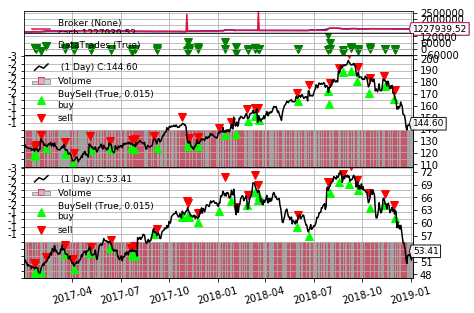

[[<matplotlib.figure.Figure at 0x20b3dfe5400>]]

In [11]:
cerebro.plot()

### Sharpe ratio, profit

In [12]:
sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
startcash = cerebro.getbroker().startingcash
endcash = cerebro.getbroker().getvalue()
profit = (endcash - startcash) / startcash

print(sharperatio)
print(profit)

1.0472010627811144
0.22793951999999978


### Trade statistics

In [13]:
n_trades = strat[0].analyzers.metrics.n_trades
n_resolved_trades = strat[0].analyzers.metrics.n_resolved_trades
n_unresolved_trades = strat[0].analyzers.metrics.n_unresolved_trades
avg_holding_period = strat[0].analyzers.metrics.avg_holding_period
len_unresolved_trade= strat[0].analyzers.metrics.len_unresolved_trade

returns = strat[0].analyzers.metrics.returns
pv = strat[0].analyzers.metrics.pv

print(n_trades, n_resolved_trades, n_unresolved_trades, avg_holding_period, len_unresolved_trade)

29 29 0 2.896551724137931 -1


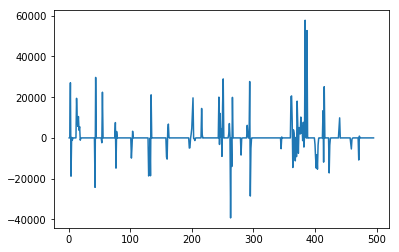

In [14]:
plt.plot(returns)
plt.show()

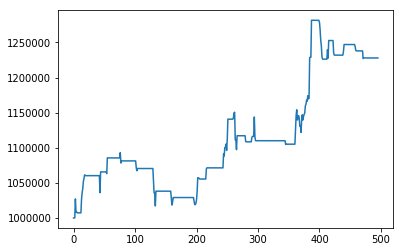

In [15]:
plt.plot(pv)
plt.show()